In [114]:
import pandas as pd
import os
from datetime import datetime, time
import matplotlib.pyplot as plt
import cv2 as cv

first_time = 2
twice_time = 7
n_sd = 10
# 讀取該資料
raw_file_path = "./data/2022_04_11_13_11_08.csv"
now_output_time = str(datetime.now().strftime('%Y-%m-%d %H-%M-%S'))
# 顏色
colorTab_More4 = ['#e8a5eb', '#facc9e', '#e8e948', '#1bb763',
                  '#25f2f3', '#1db3ea', '#d1aef8', '#c8c92c',
                  '#f32020', '#fd9b09', '#406386', '#24a1a1',
                  '#1515f8', '#959697', '#744a20', '#7b45a5']

In [115]:
def get_accumulation_time():
    df_time = df_normalization['time']
    time_ori = datetime.strptime(df_time[0], "%H:%M:%S")
    time_delta = []
    for time in df_time:
        time_now = datetime.strptime(time, "%H:%M:%S")
        time_delta.append((time_now - time_ori).seconds/60)
    df_normalization.insert(1, column="accumulation", value=time_delta)
print(df_normalization)

        time  accumulation  well_1  well_2  well_3  well_4  well_5  well_6  \
0   12:36:03      0.000000      29      15       5      45      47       7   
1   12:36:34      0.516667      30      15       5      46      48       7   
2   12:37:04      1.016667      29      15       5      47      49       7   
3   12:37:35      1.533333      29      15       5      48      50       7   
4   12:38:03      2.000000      30      16       5      49      51       7   
5   12:38:34      2.516667      30      15       5      47      49       7   
6   12:39:04      3.016667      30      16       5      48      50       7   
7   12:39:35      3.533333      29      15       5      47      49       7   
8   12:40:03      4.000000      29      15       5      47      49       7   
9   12:40:34      4.516667      29      16       5      47      49       7   
10  12:41:04      5.016667      29      15       5      48      49       7   
11  12:41:35      5.533333      29      15       5      47      

In [116]:
def get_StdDev_and_Avg():
    StdDev = []
    Avg = []
    for i in range(0, 16):
        df_current_well = df_normalization[f'well_{i+1}']
        StdDev.append(df_current_well[first_time*2:twice_time*2].std())
        Avg.append(df_current_well[first_time:twice_time].mean())
    print(StdDev)
    print(Avg)
    return StdDev, Avg

In [117]:
def normalize():
    for i in range(0, 16):
        df_current_well = df_raw[f'well_{i+1}']
        baseline = df_current_well[first_time*2:twice_time*2].mean()
        df_normalization[f'well{i+1}'] = (df_raw[f'well_{i+1}']- baseline) / baseline # normalized = (IF(t)-IF(b))/IF(b)
        if(i<8):
            print(f'A{i+1}'+" baseline value: " + str(baseline))
        else:
            print(f'B{i-7}'+" baseline value: " + str(baseline))

In [118]:
def Moving_Average():
    for i in range(0,16,1):
        well_move_average.append(df_raw["well_" + str(i+1)].rolling(window=5).mean())

In [119]:
def get_ct_threshold():
    threshold_value = []
    StdDev, Avg = get_StdDev_and_Avg()
    for i in range(0, 16):
        threshold_value.append(n_sd*StdDev[i] + Avg[i])
    return threshold_value

In [120]:
def get_ct_value(threshold_value):
    Ct_value = []
    for i in range(0, 16):
        df_current_well = df_normalization[f'well_{i+1}']
        df_accumulation = df_normalization['accumulation']
        try:
            for j, row in enumerate(df_current_well):
                if row >= threshold_value[i]:
                    # print(f"row: {row}")
                    thres_lower = df_current_well[j-1]
                    thres_upper = df_current_well[j]                
                    acc_time_lower = df_accumulation[j-1]
                    acc_time_upper = df_accumulation[j+1]
                    
                    # linear regression
                    x2 = acc_time_upper
                    y2 = thres_upper
                    x1 = acc_time_lower
                    y1 = thres_lower
                    y = threshold_value[i]
                    x = (x2-x1)*(y-y1)/(y2-y1)+x1

                    Ct_value.append(round(x, 2))
                    # print(f"Ct of well_{i+1} is {round(x, 2)}")
                    break

                # if there is no Ct_value availible
                elif j == len(df_current_well)-1:
                    Ct_value.append(99.99)
        except Exception as e:
            Ct_value.append(99.99)

    return Ct_value

In [121]:
def take_photo():        
    A1_data = []
    A2_data = []
    A3_data = []
    A4_data = []
    A5_data = []
    A6_data = []
    A7_data = []
    A8_data = []
    B1_data = []
    B2_data = []
    B3_data = []
    B4_data = []
    B5_data = []
    B6_data = []
    B7_data = []
    B8_data = []
    all_well = []
    time_array = []
    test_array = []

    for i in range(1,17,1):
        all_well.append(df_normalization["well"+str(i)].rolling(window=5).mean())
    temp_well = pd.DataFrame(all_well)
    Csv_well = temp_well.T

    for i in range(0,len(Csv_well.index),1):
        A1_data.append(Csv_well.loc[i,'well1'])
        A2_data.append(Csv_well.loc[i,'well2'])
        A3_data.append(Csv_well.loc[i,'well3'])
        A4_data.append(Csv_well.loc[i,'well4'])
        A5_data.append(Csv_well.loc[i,'well5'])
        A6_data.append(Csv_well.loc[i,'well6'])
        A7_data.append(Csv_well.loc[i,'well7'])
        A8_data.append(Csv_well.loc[i,'well8'])
        B1_data.append(Csv_well.loc[i,'well9'])
        B2_data.append(Csv_well.loc[i,'well10'])
        B3_data.append(Csv_well.loc[i,'well11'])
        B4_data.append(Csv_well.loc[i,'well12'])
        B5_data.append(Csv_well.loc[i,'well13'])
        B6_data.append(Csv_well.loc[i,'well14'])
        B7_data.append(Csv_well.loc[i,'well15'])
        B8_data.append(Csv_well.loc[i,'well16'])
        test_array.append(1.5)
    
    for j in range(0, len(Csv_well.index), 1):
        time_array.append(j / 2)
    plt.figure(figsize=(10, 2.5), dpi=100, linewidth=3)
    plt.plot(time_array,A1_data,'-',color = colorTab_More4[0], label="A1")
    plt.plot(time_array,A2_data,'-',color = colorTab_More4[1], label="A2")
    plt.plot(time_array,A3_data,'-',color = colorTab_More4[2], label="A3")
    plt.plot(time_array,A4_data,'-',color = colorTab_More4[3], label="A4")
    plt.plot(time_array,A5_data,'-',color = colorTab_More4[4], label="A5")
    plt.plot(time_array,A6_data,'-',color = colorTab_More4[5], label="A6")
    plt.plot(time_array,A7_data,'-',color = colorTab_More4[6], label="A7")
    plt.plot(time_array,A8_data,'-',color = colorTab_More4[7], label="A8")
    plt.plot(time_array,B1_data,'-',color = colorTab_More4[8], label="B1")
    plt.plot(time_array,B2_data,'-',color = colorTab_More4[9], label="B2")
    plt.plot(time_array,B3_data,'-',color = colorTab_More4[10], label="B3")
    plt.plot(time_array,B4_data,'-',color = colorTab_More4[11], label="B4")
    plt.plot(time_array,B5_data,'-',color = colorTab_More4[12], label="B5")
    plt.plot(time_array,B6_data,'-',color = colorTab_More4[13], label="B6")
    plt.plot(time_array,B7_data,'-',color = colorTab_More4[14], label="B7")
    plt.plot(time_array,B8_data,'-',color = colorTab_More4[15], label="B8")
    plt.plot(time_array,test_array,'-',color = colorTab_More4[15], label="B8")

    plt.ylim(-1,3)
    plt.title("Amplification curve")
    plt.xlabel('Time (min)')
    plt.ylabel('Normalized fluorescent intensity') 
    plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.05),
    fancybox=True, shadow=True, ncol=8,fontsize=7.5)
    plt.grid()
    plt.savefig('./result/Display_result/CT.jpg')
    plt.show()
    return Csv_well

In [122]:
def ct_calculation():
    global df_raw, df_normalization ,first_time,twice_time,n_sd,well_move_average,Csv_well
    well_move_average =[]
    # first_time = int(input("Input Start time:   "))
    # twice_time = int(input("Input End time:   "))
    # n_sd = int(input("Input Std:   "))  
    df_raw = pd.read_csv(raw_file_path)
    df_raw.reset_index(inplace=True)
        
    df_raw.rename(columns={'time':'well_1', 'A1':'well_2', 'A2':'well_3', 'A3':'well_4',
                           'A4':'well_5', 'A5':'well_6', 'A6':'well_7', 'A7':'well_8',
                           'A8':'well_9', 'B1':'well_10', 'B2':'well_11', 'B3':'well_12',
                           'B4':'well_13', 'B5':'well_14', 'B6':'well_15', 'B7':'well_16'},inplace = True)
    df_raw.drop(labels=["B8"], axis="columns")
    df_raw.rename(columns={"index": "time"},inplace=True)
    # print("first_time: " + str(first_time))
    # print("twice_time: " + str(twice_time))
    # print("n_sd: " + str(n_sd))
    print("-"*90)
    df_normalization = df_raw.copy()    #將df_raw複製給df_df_normalization
    print(df_normalization)
    print("-"*90)
    get_accumulation_time()
    print("-"*90)
    normalize()
    print("-"*90)
    threshold_value = get_ct_threshold()
    Moving_Average()
    Ct_value = get_ct_value(threshold_value)
    Csv_well = take_photo()
    save_excel = pd.DataFrame({"A1":[Ct_value[0]],"A2":[Ct_value[1]],
                               "A3":[Ct_value[2]],"A4":[Ct_value[3]],
                               "A5":[Ct_value[4]],"A6":[Ct_value[5]],
                               "A7":[Ct_value[6]],"A8":[Ct_value[7]],
                               "B1":[Ct_value[8]],"B2":[Ct_value[9]],
                               "B3":[Ct_value[10]],"B4":[Ct_value[11]],
                               "B5":[Ct_value[12]],"B6":[Ct_value[13]],
                               "B7":[Ct_value[14]],"B8":[Ct_value[15]]}
    ,index=["CT_Value"])
    save_excel.to_csv('./result/Display_result/CT_Value_'+ now_output_time + '_MA_data.csv', encoding= "utf_8_sig")
    Csv_well.to_csv("./result/Display_result/CT_Value"+ now_output_time + "all_well.csv", encoding="utf_8_sig")
    
    return Ct_value

------------------------------------------------------------------------------------------
        time  well_1  well_2  well_3  well_4  well_5  well_6  well_7  well_8  \
0   12:36:03      29      15       5      45      47       7      12      23   
1   12:36:34      30      15       5      46      48       7      12      24   
2   12:37:04      29      15       5      47      49       7      12      24   
3   12:37:35      29      15       5      48      50       7      12      24   
4   12:38:03      30      16       5      49      51       7      12      24   
5   12:38:34      30      15       5      47      49       7      12      24   
6   12:39:04      30      16       5      48      50       7      11      24   
7   12:39:35      29      15       5      47      49       7      11      24   
8   12:40:03      29      15       5      47      49       7      12      24   
9   12:40:34      29      16       5      47      49       7      12      24   
10  12:41:04      29      15 

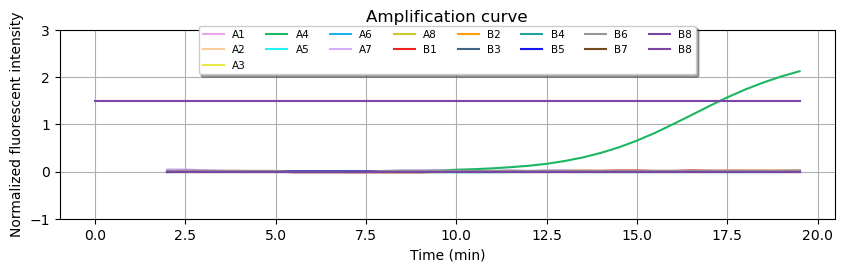

In [123]:
def main():
    ct_calculation()
if __name__ == '__main__':
    main()